In [5]:
# self-define function
from data_cleaning import cleaning_text_QA, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_MD"
# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
# nlp
import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import spacy 
nlp = spacy.load("en_core_web_lg")
from tqdm import tqdm
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# call out the model_df CSV
model_df = pd.read_csv('./main_df_output/QA13_topic_modelling_df.csv')
# model_df sort by date
model_df = model_df.sort_values(by=['date'])
pd.set_option('display.max_columns', None)
print(len(model_df))
model_df.head()


30763


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,token_len,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
4048,Blair Stewart,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,2.0,0,1,LEGAL -,4191309 Thanks very much. Good afternoon. Tw...,Thanks very much Good afternoon Two questio...,thank afternoon question chunk financing place...,"['chunk', 'financing', 'indication', 'scale', ...",12,101,12,8.416667,1.000000,6,0.020866,0.010730,0.023910,0.148783,0.022282,0.150929,0.406067,0.014734,0.005896,0.011964,0.014692,0.021430,0.147719
2361,Andy Hughes,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,136.0,0,1,LEGAL -,"15036395 Two questions, if I may. The first ...",Two questions if I may The first one is obv...,question benefit fact chunk par term credit sp...,"['chunk', 'spread', 'post', 'surprise', 'worth...",32,201,18,6.281250,1.777778,9,0.015155,0.007793,0.017366,0.016829,0.289881,0.474549,0.021231,0.010701,0.004282,0.099922,0.010671,0.015564,0.016056
27808,Tim Stedman,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,183.0,1,0,LEGAL -,"19448392 Just in terms of the $565 million, ...",Just in terms of the $ million the assets i...,term asset trust runoff book asset revph rundo...,"['trust', 'runoff', 'revph', 'rundown', 'requi...",19,117,6,6.157895,3.166667,8,0.117068,0.008575,0.019109,0.018518,0.218591,0.120625,0.023362,0.011775,0.004712,0.009562,0.312916,0.017127,0.118059
10370,Francisco Riquel,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,363.0,0,1,Mapfre SA,3050316 Hello. I have a couple of questions....,Hello I have a couple of questions First on...,couple question up press conference morning sh...,"['press', 'estate', 'inmuebles', 'reorganizati...",31,208,16,6.709677,1.937500,12,0.584922,0.006118,0.156890,0.013213,0.012706,0.014436,0.159925,0.008402,0.003362,0.006822,0.008378,0.012220,0.012606
9180,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,380.0,1,0,Mapfre SA,3910673 I will answer your first question an...,I will answer your first question and p of ...,question p filler morning sharehol way bank ba...,"['filler', 'bank', 'bank', 'bank', 'bank', 'li...",61,402,18,6.590164,3.388889,21,0.355651,0.003720,0.138946,0.008034,0.007726,0.008778,0.402104,0.005108,0.002044,0.004148,0.048646,0.007430,0.007665


# Tokenize

In [7]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [8]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_23090/458752224.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
100%|██████████| 30763/30763 [05:20<00:00, 96.03it/s] 


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,token_len,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
4048,Blair Stewart,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,2.0,0,1,LEGAL -,4191309 Thanks very much. Good afternoon. Tw...,Thanks very much Good afternoon Two questio...,thank afternoon question chunk financing place...,"[afternoon, question, chunk, financing, place,...",12,101,12,8.416667,1.000000,6,0.020866,0.010730,0.023910,0.148783,0.022282,0.150929,0.406067,0.014734,0.005896,0.011964,0.014692,0.021430,0.147719
2361,Andy Hughes,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,136.0,0,1,LEGAL -,"15036395 Two questions, if I may. The first ...",Two questions if I may The first one is obv...,question benefit fact chunk par term credit sp...,"[question, benefit, fact, chunk, term, credit,...",32,201,18,6.281250,1.777778,9,0.015155,0.007793,0.017366,0.016829,0.289881,0.474549,0.021231,0.010701,0.004282,0.099922,0.010671,0.015564,0.016056
27808,Tim Stedman,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,183.0,1,0,LEGAL -,"19448392 Just in terms of the $565 million, ...",Just in terms of the $ million the assets i...,term asset trust runoff book asset revph rundo...,"[term, asset, trust, runoff, book, asset, revp...",19,117,6,6.157895,3.166667,8,0.117068,0.008575,0.019109,0.018518,0.218591,0.120625,0.023362,0.011775,0.004712,0.009562,0.312916,0.017127,0.118059
10370,Francisco Riquel,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,363.0,0,1,Mapfre SA,3050316 Hello. I have a couple of questions....,Hello I have a couple of questions First on...,couple question up press conference morning sh...,"[couple, question, press, conference, morning,...",31,208,16,6.709677,1.937500,12,0.584922,0.006118,0.156890,0.013213,0.012706,0.014436,0.159925,0.008402,0.003362,0.006822,0.008378,0.012220,0.012606
9180,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,380.0,1,0,Mapfre SA,3910673 I will answer your first question an...,I will answer your first question and p of ...,question p filler morning sharehol way bank ba...,"[question, p, filler, morning, sharehol, bank,...",61,402,18,6.590164,3.388889,21,0.355651,0.003720,0.138946,0.008034,0.007726,0.008778,0.402104,0.005108,0.002044,0.004148,0.048646,0.007430,0.007665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,115.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. We got the claims inﬂation. I w...,Yes We got the claims inﬂation I would st t...,claim inﬂation course quer inﬂation quer inﬂat...,"[claim, inﬂation, quer, inﬂation, quer, inﬂati...",28,178,14,6.357143,2.000000,10,0.013888,0.843190,0.015914,0.015422,0.014831,0.016850,0.019456,0.009806,0.003924,0.007963,0.009779,0.014263,0.014714
16181,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,418.0,1,0,GJENSIDIGE FORSI-,19939645 The second question on the home sel...,The second question on the home seller mar...,question home seller market product year stand...,"[question, seller, market, product, year, stan...",51,296,11,5.803922,4.636364,18,0.008322,0.354963,0.009536,0.109436,0.008887,0.010097,0.011658,0.005876,0.002351,0.255260,0.005860,0.058644,0.159110
12924,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,401.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. I commented the Baltics and we ...,Yes I commented the Baltics and we have use...,time pner measure measure organization ping re...,"[time, pner, measure, measure, organization, p...",37,247,11,6.675676,3.363636,14,0.010408,0.005352,0.011926,0.512778,0.011114,0.012627,0.014580,0.070001

In [9]:
# DTM模型（Dynamic Topic Models: 加入时间因素，不同主题随着时间变动) 时间-主题词条矩阵、主题-时间词条矩阵、文档主题偏好、新文档预测、跨时间+主题属性的文档相似性
# https://cloud.tencent.com/developer/article/1435976

model_df['date'] = pd.to_datetime(model_df['date'])
model_df['year'] = model_df['date'].apply(lambda x: x.year)
model_df['month'] = model_df['date'].apply(lambda x: x.month)
model_df['quater'] = model_df['date'].apply(lambda x: x.quarter)
model_df['year_quater'] = model_df['year'].astype(str) + '-' + model_df['quater'].astype(str)
# model_df['date'] to str
model_df['date'] = model_df['date'].astype(str)
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,token_len,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,year,month,quater,year_quater
4048,Blair Stewart,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,2.0,0,1,LEGAL -,4191309 Thanks very much. Good afternoon. Tw...,Thanks very much Good afternoon Two questio...,thank afternoon question chunk financing place...,"[afternoon, question, chunk, financing, place,...",12,101,12,8.416667,1.000000,6,0.020866,0.010730,0.023910,0.148783,0.022282,0.150929,0.406067,0.014734,0.005896,0.011964,0.014692,0.021430,0.147719,2011,2,1,2011-1
2361,Andy Hughes,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,136.0,0,1,LEGAL -,"15036395 Two questions, if I may. The first ...",Two questions if I may The first one is obv...,question benefit fact chunk par term credit sp...,"[question, benefit, fact, chunk, term, credit,...",32,201,18,6.281250,1.777778,9,0.015155,0.007793,0.017366,0.016829,0.289881,0.474549,0.021231,0.010701,0.004282,0.099922,0.010671,0.015564,0.016056,2011,2,1,2011-1
27808,Tim Stedman,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,183.0,1,0,LEGAL -,"19448392 Just in terms of the $565 million, ...",Just in terms of the $ million the assets i...,term asset trust runoff book asset revph rundo...,"[term, asset, trust, runoff, book, asset, revp...",19,117,6,6.157895,3.166667,8,0.117068,0.008575,0.019109,0.018518,0.218591,0.120625,0.023362,0.011775,0.004712,0.009562,0.312916,0.017127,0.118059,2011,2,1,2011-1
10370,Francisco Riquel,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,363.0,0,1,Mapfre SA,3050316 Hello. I have a couple of questions....,Hello I have a couple of questions First on...,couple question up press conference morning sh...,"[couple, question, press, conference, morning,...",31,208,16,6.709677,1.937500,12,0.584922,0.006118,0.156890,0.013213,0.012706,0.014436,0.159925,0.008402,0.003362,0.006822,0.008378,0.012220,0.012606,2011,2,1,2011-1
9180,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,380.0,1,0,Mapfre SA,3910673 I will answer your first question an...,I will answer your first question and p of ...,question p filler morning sharehol way bank ba...,"[question, p, filler, morning, sharehol, bank,...",61,402,18,6.590164,3.388889,21,0.355651,0.003720,0.138946,0.008034,0.007726,0.008778,0.402104,0.005108,0.002044,0.004148,0.048646,0.007430,0.007665,2011,2,1,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,115.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. We got the claims inﬂation. I w...,Yes We got the claims inﬂation I would st t...,claim inﬂation course quer inﬂation quer inﬂat...,"[claim, inﬂation, quer, inﬂation, quer, inﬂati...",28,178,14,6.357143,2.000000,10,0.013888,0.843190,0.015914,0.015422,0.014831,0.016850,0.019456,0.009806,0.003924,0.007963,0.009779,0.014263,0.014714,2022,4,2,2022-2
16181,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,418.0,1,0,GJENSIDIGE FORSI-,19939645 The second question on the home sel...,The second question on the home seller mar...,question home seller market product year stand...,"[question, seller, market, product, year, stan...",51,296,11,5.803922,4.636364,18,0.008322,0.354963,0.009536,0.109436,0.008887,0.010097,0.011658,0.005876,0.002351,0.255260,0.005860,0.058644,0.159110,2022,4,2,2022-2
12924,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,401.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. I commented the Baltics and we ...,Yes I commented the Baltics and we have use...,time pner measure measure organization ping re

In [10]:
# drop the afternoon, morning, conference, today,lady, gentleman
model_df['token'] = model_df['token'].apply(lambda x: [i for i in x if i not in [
    'afternoon', 'morning', 'conference','today','lady', 'gentleman', 'presentation',
    'question','answer', 'slide',
    'proÔ¨Åt', 'eÔ¨Äect','proÔ¨Åtability','oÔ¨Ä','diÔ¨Äerent','eÔ¨Éciency','Ô¨Ågure','inÔ¨Çation','Ô¨Çow','conÔ¨Åt',
    'mm', 'mm_mm','guy','sir',' ','host_sir','bb','ty','word', 'year', 'quer','month','period', 'day', 'time','result', 'investor','week', 'update',
    'Ô¨Åre','diÔ¨Äerence','diÔ¨Écult','beneÔ¨Åt', 'business','lot','ratio','rate','quarter', 'number', 'point', 'term', 'thing', 'level', 
    'bit', 'sort', 'reason', 'management', 'fact', 'case', 'area', 'people', 'sense', 'item', 'issue','market'
     ]])
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,token_len,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,year,month,quater,year_quater
4048,Blair Stewart,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,2.0,0,1,LEGAL -,4191309 Thanks very much. Good afternoon. Tw...,Thanks very much Good afternoon Two questio...,thank afternoon question chunk financing place...,"[chunk, financing, place, indication, scale, i...",12,101,12,8.416667,1.000000,6,0.020866,0.010730,0.023910,0.148783,0.022282,0.150929,0.406067,0.014734,0.005896,0.011964,0.014692,0.021430,0.147719,2011,2,1,2011-1
2361,Andy Hughes,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,136.0,0,1,LEGAL -,"15036395 Two questions, if I may. The first ...",Two questions if I may The first one is obv...,question benefit fact chunk par term credit sp...,"[benefit, chunk, credit, spread, gain, transac...",32,201,18,6.281250,1.777778,9,0.015155,0.007793,0.017366,0.016829,0.289881,0.474549,0.021231,0.010701,0.004282,0.099922,0.010671,0.015564,0.016056,2011,2,1,2011-1
27808,Tim Stedman,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,183.0,1,0,LEGAL -,"19448392 Just in terms of the $565 million, ...",Just in terms of the $ million the assets i...,term asset trust runoff book asset revph rundo...,"[asset, trust, runoff, book, asset, revph, run...",19,117,6,6.157895,3.166667,8,0.117068,0.008575,0.019109,0.018518,0.218591,0.120625,0.023362,0.011775,0.004712,0.009562,0.312916,0.017127,0.118059,2011,2,1,2011-1
10370,Francisco Riquel,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,363.0,0,1,Mapfre SA,3050316 Hello. I have a couple of questions....,Hello I have a couple of questions First on...,couple question up press conference morning sh...,"[couple, press, sharehol, condition, estate, i...",31,208,16,6.709677,1.937500,12,0.584922,0.006118,0.156890,0.013213,0.012706,0.014436,0.159925,0.008402,0.003362,0.006822,0.008378,0.012220,0.012606,2011,2,1,2011-1
9180,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,380.0,1,0,Mapfre SA,3910673 I will answer your first question an...,I will answer your first question and p of ...,question p filler morning sharehol way bank ba...,"[p, filler, sharehol, bank, bank, portfolio, b...",61,402,18,6.590164,3.388889,21,0.355651,0.003720,0.138946,0.008034,0.007726,0.008778,0.402104,0.005108,0.002044,0.004148,0.048646,0.007430,0.007665,2011,2,1,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,115.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. We got the claims inﬂation. I w...,Yes We got the claims inﬂation I would st t...,claim inﬂation course quer inﬂation quer inﬂat...,"[claim, inﬂation, inﬂation, inﬂation, expectat...",28,178,14,6.357143,2.000000,10,0.013888,0.843190,0.015914,0.015422,0.014831,0.016850,0.019456,0.009806,0.003924,0.007963,0.009779,0.014263,0.014714,2022,4,2,2022-2
16181,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,418.0,1,0,GJENSIDIGE FORSI-,19939645 The second question on the home sel...,The second question on the home seller mar...,question home seller market product year stand...,"[seller, product, standard, estimate, requirem...",51,296,11,5.803922,4.636364,18,0.008322,0.354963,0.009536,0.109436,0.008887,0.010097,0.011658,0.005876,0.002351,0.255260,0.005860,0.058644,0.159110,2022,4,2,2022-2
12924,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,401.0,1,0,GJENSIDIGE FORSI-,5865247 Yes. I commented the Baltics and we ...,Yes I commented the Baltics and we have use...,time pner measure measure organization ping re

# Word-Length Count

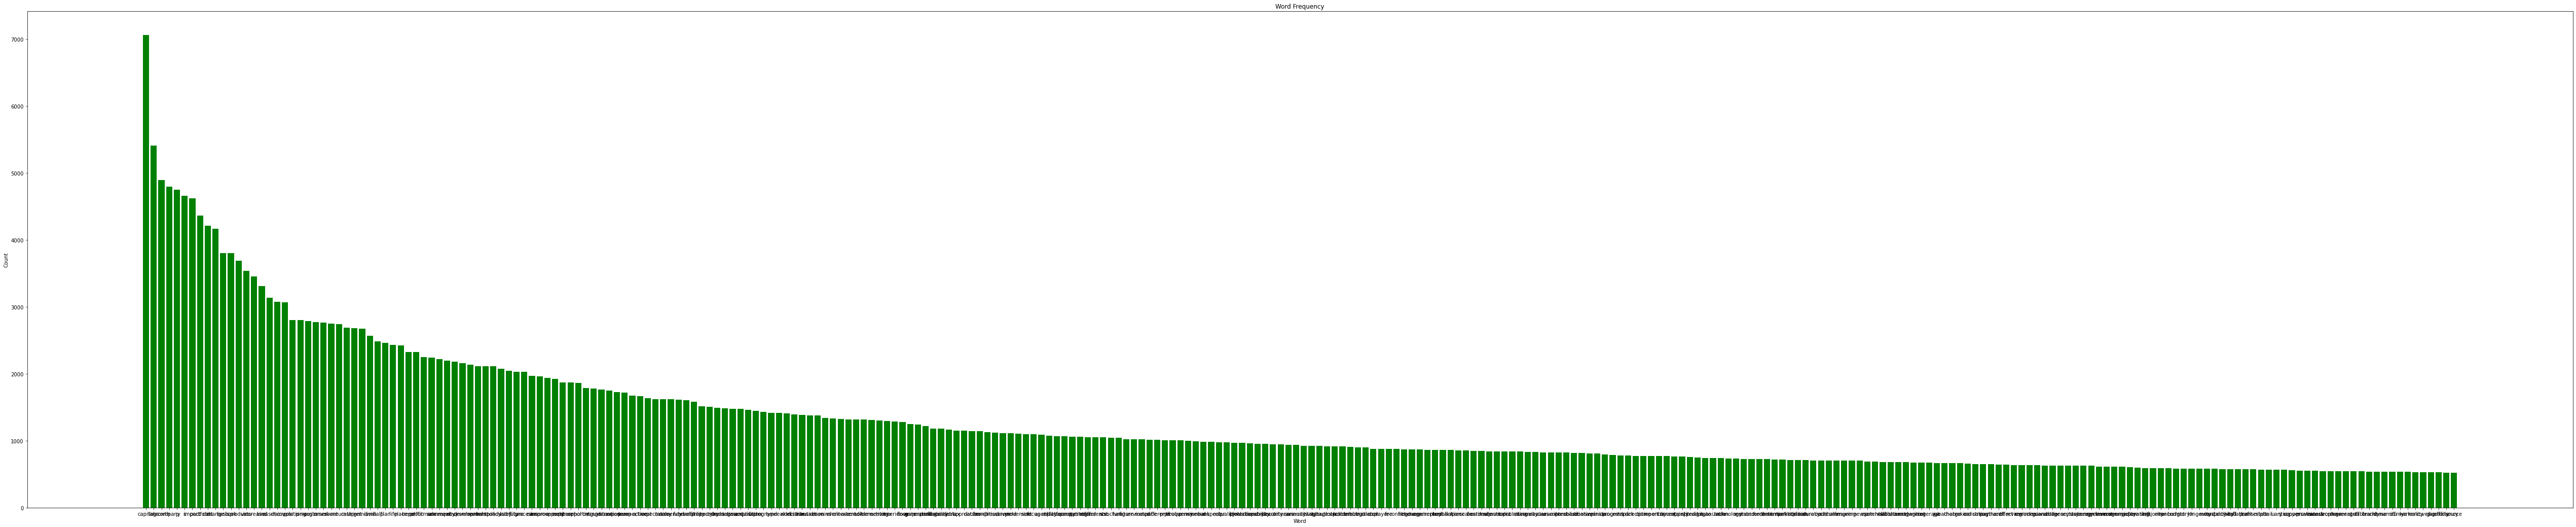

,word,freq
0,capital,7062
1,loss,5408
2,growth,4897
3,company,4792
4,p,4748
...,...,...
7825,rod,1
7826,letup,1
7827,massage,1
7828,molehill,1


In [11]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

# high frequency words excluding
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(90, 18))
plt.bar(word_fr.word[0:300], word_fr.freq[0:300], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()

# remove 50 most frequent words which is known in this context
word_list = word_fr.head(300)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]
    
word_fr

In [12]:
original_model_df = model_df.copy()
model_df['token'] = mdy_list

In [13]:
# # exclude the rows that the sentence_count is less than 3
# model_df = model_df[model_df['sentence_count']>4]
# # reset the index
# model_df = model_df.reset_index(drop=True)
# model_df_original = model_df.copy()

In [14]:
# # high frequency words excluding
# temp_token = model_df_original['token'] # .apply(remove_brackets)
# docs_tokens = []
# for i in temp_token:
#     docs_tokens.append(i)

# # word frequency
# # explore word frequencies
# word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
# word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# # visualize word frequencies
# # figure size
# fig = plt.figure(figsize=(90, 18))
# plt.bar(word_fr.word[0:150], word_fr.freq[0:150], color='green')
# plt.xlabel("Word")
# plt.ylabel("Count")
# plt.title("Word Frequency")
# plt.show()


# # remove 50 most frequent words which is known in this context
# word_list = word_fr.head(150)['word'].to_list()
# mdy_list, tmp=[],[]
# for review in docs_tokens:
#     for word in review:
#         if word not in word_list:
#             tmp.append(word)
#     mdy_list.append(tmp)
#     tmp=[]

# model_df['token'] = mdy_list
# word_fr

In [15]:
# # DTM模型（Dynamic Topic Models: 加入时间因素，不同主题随着时间变动) 时间-主题词条矩阵、主题-时间词条矩阵、文档主题偏好、新文档预测、跨时间+主题属性的文档相似性
# # https://cloud.tencent.com/developer/article/1435976

# model_df['date'] = pd.to_datetime(model_df['date'])
# model_df['year'] = model_df['date'].apply(lambda x: x.year)
# model_df['month'] = model_df['date'].apply(lambda x: x.month)
# model_df['quater'] = model_df['date'].apply(lambda x: x.quarter)
# model_df['year_quater'] = model_df['year'].astype(str) + '-' + model_df['quater'].astype(str)
# # model_df['date'] to str
# model_df['date'] = model_df['date'].astype(str)
# model_df

In [16]:
test_df = model_df.copy()
date_list = test_df['year_quater'].unique().tolist()
# if the date_list == test_df['date'], append to the dtm_list
dtm_token_list = []
dtm_token_df = []
dtm_df = pd.DataFrame()
for date in date_list:
    tmp_df = test_df[test_df['year_quater']==date]

    tmp_token_list = tmp_df['token'].to_list()
    for i in tmp_token_list:
        for k in i:
            dtm_token_list.append(k)
    dtm_token_df.append(dtm_token_list)
    dtm_token_list = []
    dtm_df['year_quater'] = date_list
dtm_df['token'] = dtm_token_df
# dtm_df drop the row 45
dtm_df = dtm_df.drop(45)
dtm_df = dtm_df.drop(44)
dtm_df = dtm_df.reset_index(drop=True)
dtm_df

,year_quater,token
0,2011-1,"[chunk, financing, reorganization, chunk, post..."
1,2011-2,"[spite, remuneration, total, incentive, contra..."
2,2011-3,"[forex, possibility, authority, composition, v..."
3,2011-4,"[congratulation, loan, euro, euro, minority, s..."
4,2012-1,"[feast, lagik, closing, offset, mos, euro, key..."
5,2012-2,"[rise, formula, sign, unwriter, pml, peak, zon..."
6,2012-3,"[saving, negative, disclosure, aspect, saving,..."
7,2012-4,"[package, transfer, transfer, technicality, be..."
8,2013-1,"[arrangement, legacy, stad, magnitude, possibi..."
9,2013-2,"[homeowner, deductible, histoal, intent, hope,..."


# Docs_tokens

In [17]:
# https://github.com/bab2min/tomotopy
# https://bab2min.github.io/tomotopy/v0.12.3/en/#tomotopy.DTModel
# https://notebook.community/pombredanne/gensim/docs/notebooks/ldaseqmodel

In [18]:
# recrate again for getting the docs_tokens
temp_token_dtm = dtm_df['token'] # .apply(remove_brackets)
docs_tokens_dtm = []
for i in temp_token_dtm:
    docs_tokens_dtm.append(i)
len(docs_tokens_dtm)

44

# docs_phrased

In [19]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram_dtm = Phrases(                              
    docs_tokens_dtm,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram_dtm = Phrases(                             
    bigram_dtm[docs_tokens_dtm],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased_dtm = [trigram_dtm[bigram_dtm[line]] for line in docs_tokens_dtm]
len(docs_tokens_dtm)

44

# corpus

In [20]:
corpus_dtm = tp.utils.Corpus() 
for i in range(len(docs_tokens_dtm)):
    # corpus_dtm.add_doc with timepoint
    corpus_dtm.add_doc(words=docs_tokens_dtm[i], timepoint=i) # dtm_df['date'][i]
print(len(corpus_dtm))

44


# model base on the topic number we select (without time series)

In [21]:
best_mdl = tp.DTModel(
    # tw= TermWeight.ONE, # term weighting scheme in TermWeight. The default value is TermWeight.ONE
    # min_cf=0, # minimum collection frequency of words
    # min_df=0, # minimum document frequency of words
    # rm_top=0, # remove top frequency words
    # transform=None, # transformation of the corpus
    k=13,
    t = len(corpus_dtm),
    corpus=corpus_dtm,
    seed = 1
    )


for i in range(0, 100, 10):
    best_mdl.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))

Iteration: 0	Log-likelihood: -7.506180392509474
Iteration: 10	Log-likelihood: -7.483357248947648
Iteration: 20	Log-likelihood: -7.452852205706287
Iteration: 30	Log-likelihood: -7.396599681808004
Iteration: 40	Log-likelihood: -7.310600102530417
Iteration: 50	Log-likelihood: -7.192019208606383
Iteration: 60	Log-likelihood: -7.051062336898305
Iteration: 70	Log-likelihood: -6.905020520368483
Iteration: 80	Log-likelihood: -6.7494260951184835
Iteration: 90	Log-likelihood: -6.606883669802167


In [22]:
wt = pd.DataFrame()
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，with required argument 'timepoint' (pos 2)
for k in range(best_mdl.k):
    words, probs, timepoints = [], [], []
    for t in range(len(corpus_dtm)):
        for word, prob in best_mdl.get_topic_words(k ,timepoint=t):
            timepoints.append(t)
            words.append(word)
            probs.append(prob)
        tmp = pd.DataFrame(
            {
                "word": words,
                "prob": np.round(probs, 3),
                "timepoint": timepoints,
                "k": np.repeat(k, len(words)),
                "sort": np.arange(0, len(words)),
            }
        )
    words, probs, timepoints = [], [], []
    wt = wt.append(tmp)
    del tmp

wt

,word,prob,timepoint,k,sort
0,ﬁgure,0.014,0,0,0
1,network,0.011,0,0,1
2,loan,0.011,0,0,2
3,layer,0.011,0,0,3
4,rdr,0.011,0,0,4
...,...,...,...,...,...
435,evice,0.008,43,12,435
436,intention,0.008,43,12,436
437,duty,0.008,43,12,437
438,severity,0.004,43,12,438


In [23]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,timepoint
0,0.069749,0.077112,0.086438,0.087420,0.086929,0.065332,0.060423,0.099691,0.080057,0.069749,0.072203,0.068277,0.076621,0
1,0.056960,0.095612,0.073950,0.081171,0.068428,0.070552,0.090940,0.084569,0.079047,0.073950,0.070977,0.081595,0.072251,1
2,0.078873,0.074762,0.069965,0.078188,0.079559,0.075447,0.093264,0.080244,0.065853,0.085041,0.079559,0.076132,0.063112,2
3,0.065798,0.087910,0.067591,0.074762,0.071177,0.077751,0.102253,0.076555,0.072970,0.067591,0.069981,0.076555,0.089105,3
4,0.062604,0.064535,0.067624,0.093886,0.059128,0.070328,0.068397,0.075349,0.107790,0.081914,0.080369,0.080755,0.087321,4
5,0.072615,0.077621,0.074180,0.086694,0.067297,0.072302,0.079498,0.092638,0.087007,0.071364,0.074805,0.074492,0.069487,5
6,0.083110,0.066763,0.075917,0.096842,0.067416,0.080494,0.073302,0.087687,0.086379,0.066763,0.059570,0.086379,0.069378,6
7,0.065141,0.079022,0.070885,0.098645,0.065620,0.108218,0.069928,0.067535,0.076629,0.072321,0.065620,0.079022,0.081415,7
8,0.081867,0.063314,0.078885,0.089487,0.059338,0.077229,0.075904,0.091807,0.063645,0.087168,0.072591,0.079217,0.079548,8
9,0.082110,0.067185,0.066652,0.127682,0.065320,0.075980,0.076247,0.091970,0.063721,0.065320,0.083176,0.070650,0.063987,9


In [24]:
# save td to csv
td.to_csv('./main_df_output/QA_DTM_td_all_time.csv', index=False) 
wt.to_csv('./main_df_output/QA_DTM_wt_all_time.csv', index=False)

In [179]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
td_plot = td.copy()
td_plot["timepoint"] = dtm_df["year_quater"].astype(str)
# td_plot["timepoint"] replace "-" to "Q"
td_plot["timepoint"] = td_plot["timepoint"].str.replace("-", "Q")

fig = make_subplots(
    rows=3, cols=1,
    column_widths=[1],
    row_heights=[2., 2., 2.],
    specs=[
        [{"type": "scatter"}],
        [{"type": "scatter"}],
        [{"type": "scatter"}]
        ], 
    subplot_titles=("2019-2021 common topics", "2015-2018 common topics", "2011-2014 common topics"),
    vertical_spacing=0.15,
    horizontal_spacing=0.1,
        )


# tp2 tp6 tp7 tp9 tp12
recent_list = [1,5,6,8,11]
for k in recent_list:
    fig.add_trace(go.Scatter(
        x=td_plot["timepoint"].astype(str),
        y=td_plot["topic_{}".format(k + 1)],
        name="Topic {}".format(k + 1),
        legendgroup='1',
        ), row=1, col=1)

# tp11, tp13, tp8, tp9 
middle_list = [7,8,10,12]
for k in middle_list:
    fig.add_trace(go.Scatter(
        x=td_plot["timepoint"].astype(str),
        y=td_plot["topic_{}".format(k + 1)],
        name="Topic {}".format(k + 1), 
        legendgroup='2',
        ), row=2, col=1)

# early stage
# tp1 tp3 tp4 tp5 tp10     
early_list = [0,2,3,4,9]
for k in early_list:
    fig.add_trace(go.Scatter(
        x=td_plot["timepoint"].astype(str),
        y=td_plot["topic_{}".format(k + 1)],
        name="Topic {}".format(k + 1), 
        legendgroup='3',
        ), row=3, col=1)

fig.update_layout(
    height=800, 
    width=1000, 
    title_text="Q&A Topics Probability Across Time", 
    xaxis3_title = 'TimePoint',
    yaxis1_title = 'Probability',
    yaxis2_title = 'Probability',
    yaxis3_title = 'Probability',
    legend_tracegroupgap = 180,
    # yaxis1_range=[0.0, 1.0],
    # # yaxis2_range=[50, 90],
    # # yaxis3_range=[50, 90]
    )

In [193]:
fig = make_subplots(
    rows=1, cols=5,
    column_widths=[2.,2.,2.,2.,2.],
    row_heights=[1.],
    specs=[
        [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}, {"type": "bar"}, {"type": "bar"}],
        ], 
    subplot_titles=("topic_2", "topic_6", "topic_7", "topic_9", "topic_12"),
    vertical_spacing=0.15,
    horizontal_spacing=0.08,
        )


recent_list = [1,5,6,8,11]
column_list = [1,2,3,4,5]
timepoint_list = [[42,40,32],[38, 37,34],[36],[33],[39]]

for i in range(0,len(recent_list)):
    wt_single_tp = pd.DataFrame()
    wt_single_tp_alltime = wt[wt['k']==recent_list[i]]
    for k in timepoint_list[i]:
        tmp = wt_single_tp_alltime[wt_single_tp_alltime['timepoint']==k]
        wt_single_tp = wt_single_tp.append(tmp)
        del tmp

    wt_single_tp = wt_single_tp[['word', 'prob']]
    # df_tp6 groupby 'word' agg 'prob'
    wt_single_tp = wt_single_tp.groupby('word').agg({'prob':'sum'})
    wt_single_tp = wt_single_tp.reset_index()
    wt_single_tp = wt_single_tp.sort_values(by='prob', ascending=False)
    wt_single_tp = wt_single_tp.reset_index(drop=True)
    wt_single_tp = wt_single_tp.head(30).sort_values(by='prob', ascending=True)
    wt_single_tp = wt_single_tp.reset_index(drop=True)
    # print("==============","Topic {}".format(recent_list[i] + 1),"================")
    # print(wt_single_tp['word'])

    fig.add_trace(go.Bar(
        y=wt_single_tp['word'],
        x=wt_single_tp['prob'],
        name="Topic {}".format(recent_list[i] + 1),
        # make the bar virtical
        orientation='h',
        ), row=1, col=column_list[i])

fig.update_layout(
    height=600,
    width=1200,
    title_text="Q&A Sorted Probablity of General Words in 2019-2021 Topics",
    xaxis1_title = 'Probability',
    xaxis2_title = 'Probability',
    xaxis3_title = 'Probability',
    xaxis4_title = 'Probability',
    xaxis5_title = 'Probability',
    yaxis1_title = 'Word',
    # make the ytick label virtical
    xaxis1_tickangle=-45,
    xaxis2_tickangle=-45,
    xaxis3_tickangle=-45,
    xaxis4_tickangle=-45,
    xaxis5_tickangle=-45,
    legend_tracegroupgap = 180,

    )

fig.show()

In [197]:
fig = make_subplots(
    rows=1, cols=3,
    column_widths=[2.,2.,2.],
    row_heights=[1.],
    specs=[
        [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}], #  {"type": "bar"}, {"type": "bar"}
        ], 
    subplot_titles=("topic_9", "topic_11", "topic_13"),
    vertical_spacing=0.15,
    horizontal_spacing=0.08,
        )


recent_list = [8,10,12]
column_list = [1,2,3]
timepoint_list = [[31, 28, 20],[27, 22, 17],[25,27,29]]

for i in range(0,len(recent_list)):
    wt_single_tp = pd.DataFrame()
    wt_single_tp_alltime = wt[wt['k']==recent_list[i]]
    for k in timepoint_list[i]:
        tmp = wt_single_tp_alltime[wt_single_tp_alltime['timepoint']==k]
        wt_single_tp = wt_single_tp.append(tmp)
        del tmp

    wt_single_tp = wt_single_tp[['word', 'prob']]
    # df_tp6 groupby 'word' agg 'prob'
    wt_single_tp = wt_single_tp.groupby('word').agg({'prob':'sum'})
    wt_single_tp = wt_single_tp.reset_index()
    wt_single_tp = wt_single_tp.sort_values(by='prob', ascending=False)
    wt_single_tp = wt_single_tp.reset_index(drop=True)
    wt_single_tp = wt_single_tp.head(30).sort_values(by='prob', ascending=True)
    wt_single_tp = wt_single_tp.reset_index(drop=True)
    # print("==============","Topic {}".format(recent_list[i] + 1),"================")
    # print(wt_single_tp['word'])

    fig.add_trace(go.Bar(
        y=wt_single_tp['word'],
        x=wt_single_tp['prob'],
        name="Topic {}".format(recent_list[i] + 1),
        # make the bar virtical
        orientation='h',
        ), row=1, col=column_list[i])

fig.update_layout(
    height=600,
    width=1200,
    title_text="Q&A Sorted Probablity of General Words in 2015-2018 Topics",
    xaxis1_title = 'Probability',
    xaxis2_title = 'Probability',
    xaxis3_title = 'Probability',
    # xaxis4_title = 'Probability',
    # xaxis5_title = 'Probability',
    yaxis1_title = 'Word',
    # make the ytick label virtical
    xaxis1_tickangle=-45,
    xaxis2_tickangle=-45,
    xaxis3_tickangle=-45,
    # xaxis4_tickangle=-45,
    # xaxis5_tickangle=-45,
    legend_tracegroupgap = 180,

    )

fig.show()

In [202]:
test = wt[wt['k']==9]
test[test['timepoint']==10]

,word,prob,timepoint,k,sort
100,bps,0.006,10,9,100
101,ﬁgure,0.006,10,9,101
102,portion,0.004,10,9,102
103,currency,0.004,10,9,103
104,link,0.004,10,9,104
105,behavior,0.004,10,9,105
106,practice,0.004,10,9,106
107,analysis,0.004,10,9,107
108,clarity,0.004,10,9,108
109,count,0.004,10,9,109


In [205]:
fig = make_subplots(
    rows=1, cols=3,
    column_widths=[2.,2.,2.],
    row_heights=[1.],
    specs=[
        [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}], #, {"type": "bar"}, {"type": "bar"}
        ], 
    subplot_titles=("topic_4", "topic_5", "topic_9"), # , "topic_9", "topic_12"
    vertical_spacing=0.15,
    horizontal_spacing=0.08,
        )


recent_list = [3,4,9]
column_list = [1,2,3]
timepoint_list = [[15 ,10, 8],[13],[10]]

for i in range(0,len(recent_list)):
    wt_single_tp = pd.DataFrame()
    wt_single_tp_alltime = wt[wt['k']==recent_list[i]]
    for k in timepoint_list[i]:
        tmp = wt_single_tp_alltime[wt_single_tp_alltime['timepoint']==k]
        wt_single_tp = wt_single_tp.append(tmp)
        del tmp

    wt_single_tp = wt_single_tp[['word', 'prob']]
    # df_tp6 groupby 'word' agg 'prob'
    wt_single_tp = wt_single_tp.groupby('word').agg({'prob':'sum'})
    wt_single_tp = wt_single_tp.reset_index()
    wt_single_tp = wt_single_tp.sort_values(by='prob', ascending=False)
    wt_single_tp = wt_single_tp.reset_index(drop=True)
    wt_single_tp = wt_single_tp.head(30).sort_values(by='prob', ascending=True)
    wt_single_tp = wt_single_tp.reset_index(drop=True)
    print("==============","Topic {}".format(recent_list[i] + 1),"================")
    print(wt_single_tp['word'])

    fig.add_trace(go.Bar(
        y=wt_single_tp['word'],
        x=wt_single_tp['prob'],
        name="Topic {}".format(recent_list[i] + 1),
        # make the bar virtical
        orientation='h',
        ), row=1, col=column_list[i])

fig.update_layout(
    height=600,
    width=1200,
    title_text="Q&A Sorted Probablity of General Words in 2011-2014 Topics",
    xaxis1_title = 'Probability',
    xaxis2_title = 'Probability',
    xaxis3_title = 'Probability',
    # xaxis4_title = 'Probability',
    # xaxis5_title = 'Probability',
    yaxis1_title = 'Word',
    # make the ytick label virtical
    xaxis1_tickangle=-45,
    xaxis2_tickangle=-45,
    xaxis3_tickangle=-45,
    # xaxis4_tickangle=-45,
    # xaxis5_tickangle=-45,
    legend_tracegroupgap = 180,

    )

fig.show()

============== Topic 4 ================
0            tool
1          choice
2        exercise
3       expansion
4        forecast
5         insight
6           lever
7        analytic
8       valuation
9               t
10           rise
11            set
12            yen
13     individual
14           pipe
15          layer
16    proposition
17        furnish
18            rdr
19     remittance
20         aspect
21       strategy
22       unwriter
23     projection
24          hedge
25     comparison
26         office
Name: word, dtype: object
============== Topic 5 ================
0     currency
1       hurdle
2        press
3    reinsurer
4       stress
5      vehicle
6       choice
7      culture
8         firm
9         pipe
Name: word, dtype: object
============== Topic 10 ================
0    analysis
1    behavior
2     clarity
3       count
4    currency
5        link
6     portion
7    practice
8         bps
9       ﬁgure
Name: word, dtype: object


In [174]:
test = wt[wt['k']==10]
print(test[test['timepoint']==27].word)
# print("====================")
# print(test[test['timepoint']==41].word)


270       proposition
271             cyber
272            hurane
273          consumer
274              ebit
275    transformation
276        innovation
277          unwriter
278             retro
279           success
Name: word, dtype: object


In [176]:
test = wt[wt['k']==8]
print(test[test['timepoint']==33].word)
print("====================")
print(test[test['timepoint']==20].word)
print("====================")
# print(test[test['timepoint']==20].word)
# print("====================")


330            vote
331           audit
332         meeting
333    remuneration
334          member
335        proposal
336      resolution
337          matter
338         auditor
339       committee
Name: word, dtype: object
200        energy
201        payout
202        buffer
203           oil
204       surplus
205      currency
206     syndicate
207        stress
208           ﬂow
209    subsidiary
Name: word, dtype: object


In [168]:
# df_tp6 = pd.DataFrame()
# test = wt[wt['k']==5]
# words = test['word'].unique().tolist()
# df_tp6['word'] = words
# time_list = [i for i in range(0, best_mdl.num_timepoints)] 
# for timepoint in time_list:
#     tmp_df = test[test['timepoint']==timepoint]
#     tmp_df  = tmp_df[['word', 'prob']]
#     # rename the column name
#     tmp_df.columns = ['word', 'prob_timepoint_'+str(timepoint)]
#     df_tp6 = df_tp6.merge(tmp_df, on=['word'], how='left')

# # fill the nan value with 0
# df_tp6 = df_tp6.fillna(0)
# df_tp6

# # sum the prob of each word in each timepoint
# df_tp6['prob_sum'] = df_tp6.iloc[:,1:].sum(axis=1)
# # sort the df by sum_prob
# df_tp6 = df_tp6.sort_values(by='prob_sum', ascending=False)
# # drop the df_tp10['sum_prob']
# df_tp6 = df_tp6.drop(['prob_sum'], axis=1)
# # RESET THE INDEX
# df_tp6 = df_tp6.reset_index(drop=True)

# # sum the over all probability for each word
# prob_sum = df_tp6.iloc[:,1:].sum(axis=1)
# prob_sum_df = df_tp6[['word']]
# prob_sum_df['Probablity'] = prob_sum
# prob_sum_df = prob_sum_df.sort_values(by=['Probablity'], ascending=False) # 
# prob_sum_df_plot = prob_sum_df.head(80)
# prob_sum_df_plot = prob_sum_df_plot.sort_values(by=['Probablity'], ascending=True)
# prob_sum_df_plot = prob_sum_df_plot.reset_index(drop=True)


# # plot prob_sum_df by bar
# fig = px.bar(prob_sum_df_plot, y='word', x='Probablity',
#                 title='Topic_6 Sorted Probablity of General Words')
# fig.update_layout(
#     height=800, 
#     width=1000, )
# fig.show()

In [160]:
# df_tp6 = pd.DataFrame()
# test = wt[wt['k']==5]
# words = test['word'].unique().tolist()
# df_tp6['word'] = words
# time_list = [i for i in range(0, best_mdl.num_timepoints)] 
# for timepoint in time_list:
#     tmp_df = test[test['timepoint']==timepoint]
#     tmp_df  = tmp_df[['word', 'prob']]
#     # rename the column name
#     tmp_df.columns = ['word', 'prob_timepoint_'+str(timepoint)]
#     df_tp6 = df_tp6.merge(tmp_df, on=['word'], how='left')

# # fill the nan value with 0
# df_tp6 = df_tp6.fillna(0)
# df_tp6

# # sum the prob of each word in each timepoint
# df_tp6['prob_sum'] = df_tp6.iloc[:,1:].sum(axis=1)
# # sort the df by sum_prob
# df_tp6 = df_tp6.sort_values(by='prob_sum', ascending=False)
# # drop the df_tp10['sum_prob']
# df_tp6 = df_tp6.drop(['prob_sum'], axis=1)
# # RESET THE INDEX
# df_tp6 = df_tp6.reset_index(drop=True)

# # sum the over all probability for each word
# prob_sum = df_tp6.iloc[:,1:].sum(axis=1)
# prob_sum_df = df_tp6[['word']]
# prob_sum_df['Probablity'] = prob_sum
# prob_sum_df = prob_sum_df.sort_values(by=['Probablity'], ascending=False) # 
# prob_sum_df = prob_sum_df.head(80) # 
# prob_sum_df

# # # plot prob_sum_df by bar
# # fig = px.bar(prob_sum_df, y='word', x='Probablity',
# #                 title='Topic_6 Sorted Probablity of General Words')
# # fig.update_layout(
# #     height=800, 
# #     width=1000, )
# # fig.show()

In [172]:
import plotly.express as px
import plotly.graph_objects as go
td_plot = td.copy()
td_plot["timepoint"] = dtm_df["year_quater"].astype(str)
# td_plot["timepoint"] replace "-" to "Q"
td_plot["timepoint"] = td_plot["timepoint"].str.replace("-", "Q")

fig = go.Figure()
for k in range(best_mdl.k):
    fig.add_trace(go.Line(
        x=td_plot["timepoint"].astype(str),
        y=td_plot["topic_{}".format(k + 1)],
        name="Topic {}".format(k + 1)
        ))
fig.update_layout(title="Topic Distribution", xaxis_title="Timepoint", yaxis_title="Probability")
# update the xticker
fig.update_xaxes(tickmode="array", tickvals=td_plot["timepoint"].astype(str), ticktext=td_plot["timepoint"])
fig.update_layout(
    autosize=False,
    width=1200,
    height=500)

# fig.update_layout(
#     xaxis_rangeslider_visible=True,
# )

fig.show()

In [173]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=td.columns,
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='All Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")

fig.update_layout(
    autosize=False,
    width=1200,
    height=500)
    
fig.show()

In [49]:
# test = wt[wt['k']==5]
# print(test[test['timepoint']==21].word)
# print("====================")
# print(test[test['timepoint']==25].word)


In [57]:
test = wt[wt['k']==3]
print(test[test['timepoint']==37].word)
print("====================")
print(test[test['timepoint']==38].word)
print("====================")
print(test[test['timepoint']==43].word)


,word,prob,timepoint,k,sort
0,quake,0.008,0,3,0
1,journey,0.008,0,3,1
2,network,0.006,0,3,2
3,backup,0.006,0,3,3
4,diﬃcult,0.006,0,3,4
...,...,...,...,...,...
435,project,0.006,43,3,435
436,evolution,0.006,43,3,436
437,leg,0.006,43,3,437
438,valuation,0.006,43,3,438


In [42]:
prob_sum_df

,word,prob_sum
0,impairment,0.063
1,inﬂation,0.054
2,synergy,0.046
3,severity,0.042
4,scheme,0.041
...,...,...
80,bulk,0.010
79,revision,0.010
72,maturity,0.010
77,flood,0.010


In [44]:
tp_1_words = prob_sum_df.word.head(50).to_list()
print(tp_1_words)

# synergy, severity, hedge, comparison, valuation, liquidity, reinvestment
# 協同效應、嚴重性、對沖、比較、估值、流動性、再投資

# vs MD
# antagonist, scheme, inflow, variability, forma, threshold, repurchase, severity, concept, creation, dynamic, milestone
# 競爭者, 術式, 流入, 可變性, 形式, 阈值, 重購, 危急性, 概念, 創立, 動態, 里程碑

['impairment', 'inﬂation', 'synergy', 'severity', 'scheme', 'hedge', 'travel', 'estate', 'channel', 'energy', 'comparison', 'conﬁdence', 'pattern', 'ﬁgure', 'agency', 'provision', 't', 'car', 'reform', 'health', 'crop', 'quota', 'valuation', 'liquidity', 'yen', 'reinvestment', 'discount', 'goal', 'partnership', 'budget', 'project', 'supply', 'remittance', 'participation', 'function', 'currency', 'economy', 'recovery', 'buffer', 'diﬃcult', 'longevity', 'infrastructure', 'mark', 'flexibility', 'profile', 'loan', 'approval', 'season', 'consumer', 'strengthen']


In [45]:
df_tp3_plot = df_tp3.T
df_tp3_plot.columns = df_tp3['word']
df_tp3_plot.reset_index(inplace=True)
df_tp3_plot.drop(df_tp3_plot.index[0], inplace=True)
df_tp3_plot.rename(columns={'index': 'timepoint'}, inplace=True)
df_tp3_plot['timepoint'] = time_list

# plot the df_tp10_plot to see
fig = px.line(df_tp3_plot, x="timepoint", y=df_tp3_plot.iloc[:,1:].columns,
                hover_data={"timepoint"},
                title='Topic 10 in Time Series')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")

fig.show()

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [ ]:
test = wt[wt['k']==2]
time_list = [40,15]
test = test[test['timepoint'].isin(time_list)]
# groupby word and get the average of prob
test = test.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
test.sort_values(by='prob', ascending=False, inplace=True)
test.T

In [66]:
test = wt[wt['k']==9]
time_list = [15]
test = test[test['timepoint'].isin(time_list)]
# groupby word and get the average of prob
test = test.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
test.sort_values(by='prob', ascending=False, inplace=True)
test.T

,2,1,6,9,3,4,7,8,0,5
word,brand,automobile,forecast,scheme,cap,channel,hedge,mortality,agency,estate
prob,0.007,0.005,0.005,0.005,0.004,0.004,0.004,0.004,0.003,0.003


In [ ]:
test = wt[wt['k']==9]
time_list = [40,15]
test = test[test['timepoint'].isin(time_list)]
# groupby word and get the average of prob
test = test.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
test.sort_values(by='prob', ascending=False, inplace=True)
test.T

In [65]:
test = wt[wt['k']==9]
time_list = [15]
test = test[test['timepoint'].isin(time_list)]
# groupby word and get the average of prob
test = test.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
test.sort_values(by='prob', ascending=False, inplace=True)
test.T

,2,1,6,9,3,4,7,8,0,5
word,brand,automobile,forecast,scheme,cap,channel,hedge,mortality,agency,estate
prob,0.007,0.005,0.005,0.005,0.004,0.004,0.004,0.004,0.003,0.003


# Early Time

In [40]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td_early = td[td['timepoint']<=15]

import plotly.express as px
fig = px.line(td_early, x="timepoint", y=['topic_1', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Early Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [25]:
# - 1 > timep 9
# - 3 > timep 10
# - 4 > timep 13
# - 5 > timep 14
# - 7 > timep 8, 11
# - 8 > timep 5

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_9 = topic_1[topic_1['timepoint']==9]
# concat
topic_1_concate = topic_1_9.copy()
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_3
topic_3 = wt[wt['k']==2] # start with 0
# select timepoint
topic_3_9 = topic_3[topic_3['timepoint']==10]
# concat
topic_3_concate = topic_3_9.copy()
topic_3_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4 = wt[wt['k']==3] # start with 0
# select timepoint
topic_4_13 = topic_4[topic_4['timepoint']==13]
# concat
topic_4_concate = topic_4_13.copy()
topic_4_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5= wt[wt['k']==4] # start with 0
# select timepoint
topic_5_14 = topic_5[topic_5['timepoint']==14]
# concat 
topic_5_concat = topic_5_14.copy()
topic_5_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_7
topic_7= wt[wt['k']==6] # start with 0
# select timepoint
topic_7_8 = topic_7[topic_7['timepoint']==8]
topic_7_11 = topic_7[topic_7['timepoint']==11]
# concat 
topic_7_concat = pd.concat([topic_7_8, topic_7_11], ignore_index=True)
topic_7_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_8
topic_8 = wt[wt['k']==7] # start with 0
# select timepoint
topic_8_5 = topic_8[topic_8['timepoint']==5]
# concat
topic_8_concate = topic_8_5.copy()
topic_8_concate.sort_values(by='prob', ascending=False, inplace=True)

In [26]:
# concat
topic_all_early = pd.concat([topic_1_concate, topic_3_concate, topic_4_concate, topic_5_concat, topic_7_concat, topic_8_concate], ignore_index=True)
# groupby word and get the average of prob
topic_all_early = topic_all_early.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_early.sort_values(by='prob', ascending=False, inplace=True)
topic_all_early.T

,36,32,2,3,1,23,22,28,4,13,38,33,24,31,17,39,15,14,26,34,10,9,8,7,6,27,20,11,35,37,25,21,29,30,19,18,16,12,5,0
word,stock,scheme,annuity,auto,agent,platform,pension,rating,bank,fee,transcript,security,player,respect,investor,weather,guarantee,government,projection,size,competitor,competition,charge,channel,capacity,protection,operation,datum,space,structure,problem,option,relationship,requirement,motor,measure,idea,employee,capability,adtage
prob,0.007333,0.005,0.00475,0.004,0.004,0.003667,0.003667,0.0035,0.0032,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.00275,0.00275,0.0025,0.0025,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002


# Middle Time

In [39]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td_middle = td[td['timepoint']>15]
td_middle = td_middle[td_middle['timepoint']<=30]

import plotly.express as px
fig = px.line(td_middle, x="timepoint", y=['topic_1', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Middle Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [35]:
# - 1 > timep 19
# - 3 > timep 24, 25
# - 4 > timep 16, 22, 23
# - 5 > timep 18
# - 7 > timep 20, 26, 27, 29, 30
# - 8 > timep 28

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_19 = topic_1[topic_1['timepoint']==19]
# concat
topic_1_concate = topic_1_19.copy()
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_3
topic_3= wt[wt['k']==2] # start with 0
# select timepoint
topic_3_24 = topic_3[topic_3['timepoint']==24]
topic_3_25 = topic_3[topic_3['timepoint']==25]
# concat 
topic_3_concat = pd.concat([topic_3_24, topic_3_25], ignore_index=True)
topic_3_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4= wt[wt['k']==3] # start with 0
# select timepoint
topic_4_16 = topic_4[topic_4['timepoint']==16]
topic_4_22 = topic_4[topic_4['timepoint']==22]
topic_4_23 = topic_4[topic_4['timepoint']==23]
# concat 
topic_4_concat = pd.concat([topic_4_16, topic_4_22, topic_4_23], ignore_index=True)
topic_4_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5 = wt[wt['k']==4] # start with 0
# select timepoint
topic_5_18 = topic_5[topic_5['timepoint']==18]
# concat
topic_5_concate = topic_5_18.copy()
topic_5_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_7
topic_7= wt[wt['k']==6] # start with 0
# select timepoint
topic_7_20 = topic_7[topic_7['timepoint']==20]
topic_7_26 = topic_7[topic_7['timepoint']==26]
topic_7_27 = topic_7[topic_7['timepoint']==27]
topic_7_29 = topic_7[topic_7['timepoint']==29]
topic_7_30 = topic_7[topic_7['timepoint']==30]
# concat 
topic_7_concat = pd.concat([topic_7_20, topic_7_26, topic_7_27, topic_7_29, topic_7_30], ignore_index=True)
topic_7_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_8
topic_8 = wt[wt['k']==7] # start with 0
# select timepoint
topic_8_28 = topic_8[topic_8['timepoint']==28]
# concat
topic_8_concate = topic_8_28.copy()
topic_8_concate.sort_values(by='prob', ascending=False, inplace=True)

In [36]:
# concat
topic_all_middle = pd.concat([topic_1_concate, topic_3_concat, topic_4_concat, topic_5_concate, topic_7_concat, topic_8_concate], ignore_index=True)
# groupby word and get the average of prob
topic_all_middle = topic_all_middle.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_middle.sort_values(by='prob', ascending=False, inplace=True)
topic_all_middle.T

,47,36,24,28,49,10,32,58,50,60,20,54,8,6,61,52,35,41,1,33,53,55,37,9,7,4,3,59,2,16,43,44,0,45,46,48,51,56,57,42,31,40,39,5,11,12,13,14,15,17,18,19,21,22,23,25,26,29,38,62,27,30,34
word,rule,platform,inflation,meeting,sensitivity,car,motor,technology,service,unwriter,fee,state,capability,board,vote,solution,pension,regard,agent,operation,spread,stock,pner,capacity,buyback,bank,auto,transcript,annuity,datum,relationship,remittance,adjustment,report,requirement,scale,size,structure,synergy,regulator,mortgage,quality,proﬁt,bb,casualty,competitor,condition,contract,contribution,duration,energy,entity,frequency,guarantee,hand,investor,item,member,protection,weather,marketplace,mortality,opinion
prob,0.007,0.0055,0.005333,0.005,0.004167,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.003667,0.003667,0.003667,0.003667,0.0036,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.003333,0.003273,0.00325,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.002,0.002,0.002


# Recent Time

In [43]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td_recent = td[td['timepoint']>30]

import plotly.express as px
fig = px.line(td_recent, x="timepoint", y=['topic_1', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Recent Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()


In [44]:
# - 1 > timep 33
# - 3 > timep 31, 43
# - 4 > timep 45
# - 5 > timep 32, 34
# - 7 > timep 36, 37, 39, 40 
# - 8 > timep 42

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_33 = topic_1[topic_1['timepoint']==33]
# concat
topic_1_concate = topic_1_33.copy()
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_3
topic_3= wt[wt['k']==2] # start with 0
# select timepoint
topic_3_31 = topic_3[topic_3['timepoint']==31]
topic_3_43 = topic_3[topic_3['timepoint']==43]
# concat 
topic_3_concat = pd.concat([topic_3_31, topic_3_43], ignore_index=True)
topic_3_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4 = wt[wt['k']==3] # start with 0
# select timepoint
topic_4_45 = topic_4[topic_4['timepoint']==45]
# concat
topic_4_concate = topic_4_45.copy()
topic_4_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5= wt[wt['k']==4] # start with 0
# select timepoint
topic_5_32 = topic_5[topic_5['timepoint']==32]
topic_5_34 = topic_5[topic_5['timepoint']==34]
# concat 
topic_5_concat = pd.concat([topic_5_32, topic_5_34], ignore_index=True)
topic_5_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_7
topic_7= wt[wt['k']==6] # start with 0
# select timepoint
topic_7_36 = topic_7[topic_7['timepoint']==36]
topic_7_37 = topic_7[topic_7['timepoint']==37]
topic_7_39 = topic_7[topic_7['timepoint']==39]
topic_7_40 = topic_7[topic_7['timepoint']==40]
# concat 
topic_7_concat = pd.concat([topic_7_36, topic_7_37, topic_7_39, topic_7_40], ignore_index=True)
topic_7_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_8
topic_8 = wt[wt['k']==7] # start with 0
# select timepoint
topic_8_42 = topic_8[topic_8['timepoint']==42]
# concat
topic_8_concate = topic_8_42.copy()
topic_8_concate.sort_values(by='prob', ascending=False, inplace=True)


In [45]:
# concat
topic_all_recent = pd.concat([ topic_1_concate, topic_3_concat, topic_4_concat, topic_5_concat, topic_7_concat, topic_8_concate], ignore_index=True)
# groupby word and get the average of prob
topic_all_recent = topic_all_recent.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_recent.sort_values(by='prob', ascending=False, inplace=True)
topic_all_recent.T

,47,23,27,63,5,15,43,17,24,51,29,0,10,37,50,49,54,41,60,62,36,32,31,28,64,65,16,9,21,6,58,33,12,59,1,53,2,34,61,4,11,3,57,56,55,7,52,8,46,48,25,30,20,19,35,18,38,39,40,14,42,13,44,45,22,26
word,rule,fee,inflation,vote,board,coverage,report,datum,frequency,service,inﬂation,agent,casualty,platform,sensitivity,scenario,space,regulator,travel,unwriter,pension,mortality,meeting,interruption,week,worker,crisis,car,estate,buyback,synergy,mortgage,condition,transcript,annuity,solution,approach,motor,uncertainty,bank,competitor,audit,stock,statement,spread,capability,severity,capacity,revenue,scale,guarantee,item,duration,diﬀerent,operation,digit,pner,protection,quality,contribution,relationship,contract,requirement,respect,estimate,hand
prob,0.007,0.007,0.006714,0.005,0.005,0.005,0.005,0.004667,0.004667,0.0045,0.0045,0.0045,0.004333,0.004333,0.0042,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.003833,0.0035,0.0035,0.0035,0.003444,0.003333,0.003333,0.003333,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.002667,0.002667


In [46]:
# topic_all_recently to csv
topic_all_recent.to_csv('./main_df_output/QA_topic_all_recently.csv')
topic_all_early.to_csv('./main_df_output/QA_topic_all_early.csv')
topic_all_middle.to_csv('./main_df_output/QA_topic_all_middle.csv')